# ATAC enrichment (in python)

In [1]:
import pandas as pd
from pybedtools import BedTool
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.8-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'silver', 'slategrey'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

In [4]:
cts = ['B','T8', 'T4', 'NK', 'ncM', 'cM']

In [5]:
data_path = '/data_volume/memento/lupus/'

In [6]:
atac = pd.read_csv('/data_volume/memento/lupus/atac_enrichment/sorted_simple_atac_lineage_groups3.bed.gz', sep='\t')


### Pseudobulk vs memento effect size and log(P)

In [7]:
pop = 'asian'
for ct in cts:
    
    mem = pd.read_csv('/data_volume/memento/lupus/full_analysis/memento/100kb/{}_{}.csv'.format(pop,ct))\
        .add_suffix('_mem')\
        .rename(columns={'SNP_mem':'SNP', 'gene_mem':'gene', 'p.value_mem':'p-value_mem'})
    meq = pd.read_csv('/data_volume/memento/lupus/full_analysis/mateqtl/outputs/{}_{}_all_hg19.csv'.format(pop,ct), sep='\t')\
        .add_suffix('_meq')\
        .rename(columns={'SNP_meq':'SNP', 'gene_meq':'gene'})
    merged = mem.merge(meq, on=['SNP', 'gene'], how='inner')
#     merged.to_csv('/data_volume/memento/lupus/atac_enrichment/merged_eqtls/{}_{}_merged.tsv'.format(pop, ct), sep='\t', index=False)
    
    break

In [8]:
mem.shape

(1781343, 6)

In [9]:
meq.shape

(1813907, 6)

In [10]:
merged.shape

(1780402, 10)

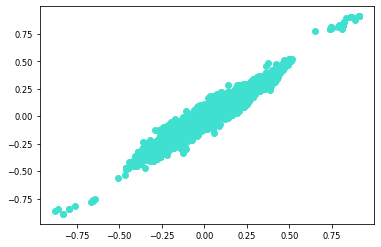

In [11]:
plt.scatter(merged['beta_mem'], merged['beta_meq'])

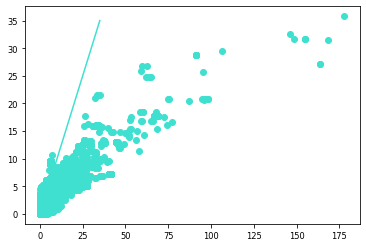

In [12]:
plt.scatter(-np.log10(merged['p-value_mem']), -np.log10(merged['p-value_meq']))
plt.plot([0, 35], [0, 35])

### Make heatmaps

In [21]:
def get_heatmap(pop, method):
    all_result = []
    for ct in cts:
        atac_result = pd.read_csv(data_path + 'atac_enrichment/100kb/{}_{}_{}.out'.format(pop, method, ct), sep='\t')
        atac_result['ct'] = ct
        all_result.append(atac_result)
    all_result = pd.concat(all_result)
    all_result['logp'] = -np.log10(all_result['pval'])
    
    heatmap = all_result.pivot('group', 'ct', 'logp').loc[['B', 'T', 'nk', 'myeloid']].loc[:, ['B', 'T4', 'T8',  'NK','cM', 'ncM',]]
    return heatmap

In [22]:
get_heatmap('asian', 'memento')

ct,B,T4,T8,NK,cM,ncM
group,,,,,,
B,8.044003,0.117830,0.002760,0.434179,0.114942,1.634820
T,0.796102,3.033815,1.527769,2.119126,0.066949,0.079797
nk,0.902028,0.140687,4.054317,7.176116,0.155688,4.204980
myeloid,0.161316,0.001976,1.198361,0.002745,10.670139,5.848707


In [23]:
get_heatmap('asian', 'matqetl')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ct,B,T4,T8,NK,cM,ncM
group,,,,,,
B,1.375918,0.069151,0.003853,1.536125e-02,3.335886e-02,0.060340
T,0.000543,0.970249,0.237444,8.803737e-03,5.507834e-07,0.015648
nk,0.581047,0.411361,1.607285,1.589017e+00,7.507291e-04,0.013147
myeloid,0.000024,0.015321,0.258989,5.761041e-08,1.765596e-01,0.339022


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


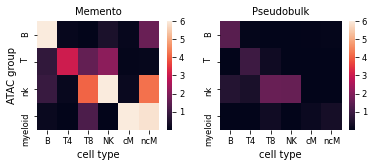

In [27]:
plt.figure(figsize=(6,2));
vmax = 6
plt.subplot(1, 2,1)
sns.heatmap(get_heatmap('asian', 'memento'), vmax=vmax)
plt.ylabel('ATAC group'); plt.xlabel('cell type')
plt.title('Memento')
plt.subplot(1, 2,2)
sns.heatmap(get_heatmap('asian', 'matqetl'), vmax=vmax)
plt.ylabel(None); plt.xlabel('cell type')
plt.title('Pseudobulk')
plt.savefig('atac_heatmap.pdf', bbox_inches='tight')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


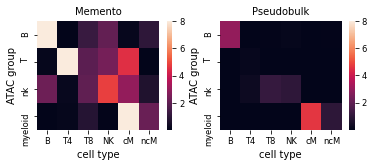

In [28]:
plt.figure(figsize=(6,2));
vmax = 8
plt.subplot(1, 2,1)
sns.heatmap(get_heatmap('eur', 'memento'), vmax=vmax)
plt.ylabel('ATAC group'); plt.xlabel('cell type')
plt.title('Memento')
plt.subplot(1, 2,2)
sns.heatmap(get_heatmap('eur', 'matqetl'), vmax=vmax)
plt.ylabel('ATAC group'); plt.xlabel('cell type')
plt.title('Pseudobulk')
plt.savefig('atac_heatmap_eur.pdf', bbox_inches='tight')

### Performance enhancements for matching single cell eQTLs + ATAC data

In [4]:
matched_pairs = [
    ('B', 'B'),
    ('T4', 'T'),
    ('T8', 'T'),
    ('T8', 'nk'),
    ('NK', 'nk'),
    ('cM', 'myeloid'),
    ('ncM', 'myeloid'),
]

In [5]:
def lognorm_sigma(row):
    rvs = stats.norm.rvs(loc=row['U_stat'], scale=row['sigma'], size=5000)
    return np.std(np.log(rvs))

In [11]:
result = []
for pop in ['asian', 'eur']:
    for ct, atac_group in matched_pairs:
        for method in [ 'mateqtl','memento']:
        
            data = pd.read_table(data_path + 'atac_enrichment/peaks/{}/{}_{}_{}.txt'.format(method, pop, ct, atac_group))
            
            U_stat, mw_pv = stats.mannwhitneyu(data.query('in_peak==1')['pv'], data.query('in_peak==0')['pv'], alternative='less')
            n1, n2 = data.query('in_peak==1').shape[0], data.query('in_peak==0').shape[0]
            mu =n1*n2/2
            sigma = np.sqrt((n1*n2)*(n1+n2+1)/12)
            zscore = (U_stat-mu)/sigma
            
            result.append((
                pop,
                method,
                ct, 
                atac_group,
                U_stat,
                mu,
                sigma, 
                zscore,
                mw_pv
            ))
result = pd.DataFrame(result, columns=['pop', 'method','ct', 'atac_group', 'U_stat', 'mu', 'sigma', 'zscore', 'pv'])


In [12]:
result['log_sigma'] = result.apply(lognorm_sigma, axis=1)
result['log_U_stat'] = np.log(result['U_stat'])

In [13]:
from matplotlib.colors import ListedColormap
cmap = sns.color_palette('Set2')

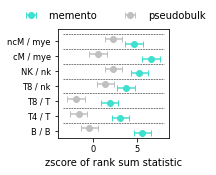

In [16]:
plt.figure(figsize=(2, 2))

df = result.query('pop == "asian" & method == "memento"')
plt.errorbar(-df['zscore'], np.arange(df.shape[0])*2-0.3,xerr=1, fmt="o", capsize=3);

df = result.query('pop == "asian" & method == "mateqtl"')
plt.errorbar(-df['zscore'], np.arange(df.shape[0])*2+0.3,xerr=1, fmt="o", capsize=3);

plt.legend(['memento ', 'pseudobulk'], loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, frameon=False)

# plt.xticks([])
lims = plt.xlim()
for x in np.arange(df.shape[0])*2+1:
    plt.plot(lims, [x, x], '--', lw=0.5, color='k')
# plt.xlim(lims)

plt.yticks(np.arange(df.shape[0])*2, df['ct'] + ' / ' + df['atac_group'].apply(lambda x: 'mye' if x == 'myeloid' else x));
plt.xlabel('zscore of rank sum statistic')
# plt.xticks(np.arange(-5, 5))
plt.savefig('matched_enrichment.pdf', bbox_inches='tight')

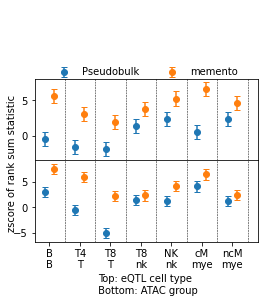

In [12]:
plt.figure(figsize=(4, 3))
plt.subplots_adjust(hspace=0.0)
plt.subplot(2, 1, 1)
df = result.query('pop == "asian" & method == "mateqtl"')
plt.errorbar(np.arange(df.shape[0])*2-0.3, -df['zscore'], yerr=1, fmt="o", capsize=3);

df = result.query('pop == "asian" & method == "memento"')
plt.errorbar(np.arange(df.shape[0])*2+0.3, -df['zscore'], yerr=1, fmt="o", capsize=3);

plt.legend(['Pseudobulk ', 'memento'], loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, frameon=False)

plt.xticks([])
lims = plt.ylim()
for x in np.arange(df.shape[0])*2+1:
    plt.plot([x, x], lims, '--', lw=0.5, color='k')
plt.ylim(lims)
    
plt.subplot(2, 1, 2)

df = result.query('pop == "eur" & method == "mateqtl"')
plt.errorbar(np.arange(df.shape[0])*2-0.3, -df['zscore'], yerr=1, fmt="o", capsize=3);

df = result.query('pop == "eur" & method == "memento"')
plt.errorbar(np.arange(df.shape[0])*2+0.3, -df['zscore'], yerr=1, fmt="o", capsize=3);

lims = plt.ylim()
for x in np.arange(df.shape[0])*2+1:
    plt.plot([x, x], lims, '--', lw=0.5, color='k')
plt.ylim(lims)
    
plt.xlabel('Top: eQTL cell type \n Bottom: ATAC group')

plt.savefig('matched_atac_enrichment.pdf', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

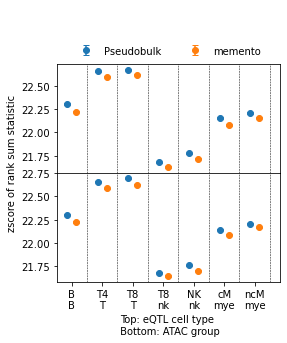

<Figure size 432x288 with 0 Axes>

In [180]:
plt.figure(figsize=(4, 4))
plt.subplots_adjust(hspace=0.)
plt.subplot(2, 1, 1)
df = result.query('pop == "asian" & method == "mateqtl"')
plt.errorbar(np.arange(df.shape[0])*2-0.3, df['log_U_stat'], yerr=df['log_sigma'], fmt="o", capsize=3);

df = result.query('pop == "asian" & method == "memento"')
plt.errorbar(np.arange(df.shape[0])*2+0.3, df['log_U_stat'], yerr=df['log_sigma'], fmt="o", capsize=3);

plt.legend(['Pseudobulk ', 'memento'], loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, frameon=False)

plt.xticks([])
lims = plt.ylim()
for x in np.arange(df.shape[0])*2+1:
    plt.plot([x, x], lims, '--', lw=0.5, color='k')
plt.ylim(lims)
plt.ylabel('zscore of rank sum statistic                            ')
    
plt.subplot(2, 1, 2)

df = result.query('pop == "eur" & method == "mateqtl"')
plt.errorbar(np.arange(df.shape[0])*2-0.3, df['log_U_stat'], yerr=df['log_sigma'], fmt="o", capsize=3);

df = result.query('pop == "eur" & method == "memento"')
plt.errorbar(np.arange(df.shape[0])*2+0.3, df['log_U_stat'], yerr=df['log_sigma'], fmt="o", capsize=3);

lims = plt.ylim()
for x in np.arange(df.shape[0])*2+1:
    plt.plot([x, x], lims, '--', lw=0.5, color='k')
plt.ylim(lims)
    
plt.xticks(np.arange(df.shape[0])*2, df['ct'] + '\n' + df['atac_group'].apply(lambda x: 'mye' if x == 'myeloid' else x));
plt.xlabel('Top: eQTL cell type \n Bottom: ATAC group')
plt.figure()

In [143]:
df

,pop,method,ct,atac_group,U_stat,mu,sigma,zscore,pv
15,eur,memento,B,B,4.490105e+09,4.704753e+09,2.851038e+07,-7.528772,2.560991e-14
17,eur,memento,T4,T,6.474440e+09,6.673428e+09,3.358292e+07,-5.925280,1.558829e-09
19,eur,memento,T8,T,6.696924e+09,6.773260e+09,3.407579e+07,-2.240184,1.253949e-02
21,eur,memento,T8,nk,2.506231e+09,2.554916e+09,2.092836e+07,-2.326259,1.000237e-02
23,eur,memento,NK,nk,2.655937e+09,2.747217e+09,2.189366e+07,-4.169263,1.527933e-05
25,eur,memento,cM,myeloid,3.911194e+09,4.084836e+09,2.700301e+07,-6.430458,6.361022e-11
27,eur,memento,ncM,myeloid,4.230487e+09,4.300527e+09,2.829509e+07,-2.475357,6.655151e-03


In [184]:
rvs = stats.norm.rvs(loc=4.490105e+09, scale=2.851038e+07, size=5000)

In [186]:
np.log(rvs).mean()

22.22512485629938

In [188]:
np.log(rvs).std()

0.006419908036991224

<AxesSubplot:ylabel='Density'>

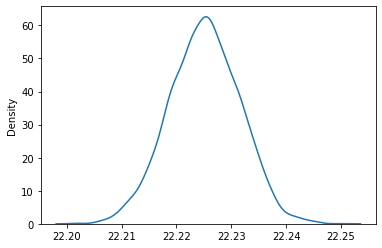

In [185]:
sns.kdeplot(np.log(rvs))

In [149]:
np.std(np.log(rvs))

0.00631101719753528

In [141]:

np.log(df['U_stat'])

15    22.225142
17    22.591128
19    22.624914
21    21.642046
23    21.700063
25    22.087109
27    22.165583
Name: U_stat, dtype: float64

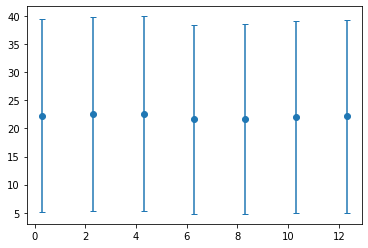

In [140]:
plt.errorbar(np.arange(df.shape[0])*2+0.3, np.log(df['U_stat']), yerr=np.log(df['sigma']), fmt="o", capsize=3);


In [139]:
df['sigma']

15    2.851038e+07
17    3.358292e+07
19    3.407579e+07
21    2.092836e+07
23    2.189366e+07
25    2.700301e+07
27    2.829509e+07
Name: sigma, dtype: float64